## Import packages

In [78]:
from datetime import datetime
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import pickle

import phik
from phik import phik_matrix, significance_matrix

from pyod.models.mad import MAD
import seaborn as sns

from scipy.stats import skew
from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, SGDRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.svm import SVR

from xgboost import XGBRegressor

## Load data

In [4]:
# Columns to exclude
cols_drop = ['amenities', 'calendar_last_scraped', 'calendar_updated', 'description', 'host_about',
             'host_has_profile_pic', 'host_id', 'host_location', 'host_name', 'host_neighbourhood', 
             'host_picture_url', 'host_thumbnail_url', 'host_url', 'id', 'latitude', 'last_scraped',
             'license', 'listing_url', 'longitude', 'name', 'neighborhood_overview', 'neighbourhood', 
             'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'picture_url', 'scrape_id', 'source']

# Read the CSV file and exclude the specified columns
df = pd.read_csv('listings.csv', usecols=lambda col: col not in cols_drop,
                 parse_dates=['first_review', 'last_review', 'host_since'])

## Turn price into integers

In [5]:
df['price'] = df['price'].str.replace('$','').str.replace(',','').str.replace('.00','').astype(int)

## Turn string rates into floats

In [6]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%','').astype(float)/100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%','').astype(float)/100

## Get mean of review scores

In [7]:
review_scores = [col for col in df.columns if 'score' in col]
df.loc[:, 'review_scores_mean'] = df.loc[:, review_scores].mean(axis=1)
df.drop(review_scores, axis=1, inplace=True)

## Encode binary features

In [8]:
cols_binary = ['host_is_superhost', 'host_identity_verified','has_availability', 'instant_bookable']

for col in cols_binary:
    # Encode t/f to 1/0 
    df[col] = np.where(df[col] == 't', 1,
                       np.where(df[col] == 'f', 0, np.nan))

    # Check if there are any NA values in the column
    if df[col].isna().any():
        # Convert the column to float if NA values are present
        df[col] = df[col].astype(float)
    else:
        # Convert the column to int8 if there are no NA values
        df[col] = df[col].astype(np.int8)

## Extract floats from bathrooms_text column

In [9]:
# Regular expression pattern to extract float numbers
pattern = r'(\d+(?:\.\d+)?)'
    
df['bathrooms'] = df['bathrooms_text'].str.extract(pattern).astype(float)

# Map remaining text-based values
mapping = {'Shared half-bath': 0.5, 'Half-bath': 0.5, 'Private half-bath': 0.5}
df.loc[df['bathrooms'].isna(), 'bathrooms'] = df.loc[df['bathrooms'].isna(), 'bathrooms_text'].map(mapping)

# Drop bathrooms_text column
df.drop(axis=1, columns=['bathrooms_text'], inplace=True)

## Turn dates into duration periods

In [10]:
# Date columns .to_datetime() and get duration in days until data retrieval
# End date from http://insideairbnb.com for Melbourne, Australia
end_date = datetime.strptime('13-03-2023', '%d-%m-%Y')

# Convert date columns to datetime and calculate the days passed from the end date
date_columns = ['host_since', 'first_review', 'last_review']

for col in date_columns:
    # Convert the column to datetime format
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
    # Calculate the number of days passed from the end date
    df[col] = (end_date - df[col]).dt.days

## Transform categorical features

In [11]:
cols_cat = ['host_response_time', 'host_verifications', 'property_type', 'room_type']
for col in cols_cat:
    df[col] = df[col].astype('category')

## Feature selection
### Pearson correlation between features and price

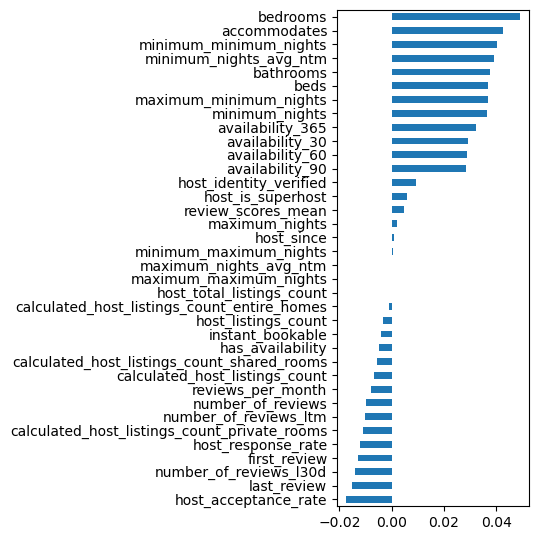

In [12]:
f = plt.figure(figsize=(5.5, 5.5))
# Get Pearson correlation between the price and features, sort
# Drop the price itself and plot horizontal bar chart
df.select_dtypes(include=np.number).corr().loc['price'].sort_values()[:-1].plot.barh()
plt.tight_layout()

The figure shows the linear correlation between each feature and the target. Let's also examine the corresponding statistical significance with alpha = 0.05 and assign correlation categories.

In [13]:
# Create a dataframe for the pearson correlations
df_pearson_price = pd.DataFrame(index=df.select_dtypes(include=np.number).drop(columns='price').columns,
                                columns=['corr', 'p_value', 'sig', 'cat'])

# Iterate over columns in the DataFrame (excluding 'price')
for col in df.drop(columns='price').columns:
    # Check if the column contains numeric data
    if is_numeric_dtype(df[col]):
        # Create a boolean mask to filter out rows with NaN values
        valid_mask = np.logical_and(~np.isnan(df[col]), ~np.isnan(df['price']))
        # Calculate Pearson correlation and p-value, considering only valid non-NaN values
        df_pearson_price.loc[col, ['corr', 'p_value']] = pearsonr(df[col][valid_mask], df['price'][valid_mask])

# Check for statistical significance with alpha = 0.05
df_pearson_price.loc[:,'sig'] = df_pearson_price['p_value']<0.05

# Define the cut points and labels for the correlation categories
cut_points = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['very weak', 'weak', 'moderate', 'strong', 'very strong']

# Map the values in 'corr' to the corresponding categories
df_pearson_price['cat'] = pd.cut(np.abs(df_pearson_price['corr']),
                                 bins=cut_points,
                                 labels=labels,
                                 include_lowest=True)

df_pearson_price.sort_values(by='corr', ascending=False)

corr   p_value    sig  \
bedrooms                                      0.049185       0.0   True   
accommodates                                  0.042603       0.0   True   
minimum_minimum_nights                        0.040409       0.0   True   
minimum_nights_avg_ntm                        0.039271       0.0   True   
bathrooms                                     0.037432       0.0   True   
beds                                          0.036806       0.0   True   
maximum_minimum_nights                        0.036681       0.0   True   
minimum_nights                                0.036546       0.0   True   
availability_365                              0.032175  0.000004   True   
availability_30                               0.029324  0.000024   True   
availability_60                               0.028757  0.000034   True   
availability_90                               0.028573  0.000038   True   
host_identity_verified                        0.009423   0.17451  False   
host_is_superhost                             0.005654   0.41528  False   
review_scores_mean                             0.00485  0.528086  False   
maximum_nights                                0.002191  0.752238  False   
host_since                                    0.000948  0.891339  False   
minimum_maximum_nights                        0.000307  0.964714  False   
maximum_nights_avg_ntm                         0.00026   0.97009  False   
maximum_maximum_nights                         0.00026    0.9701  False   
host_total_listings_count                    -0.000059  0.993243  False   
calculated_host_listings_count_entire_homes   -0.00086  0.901367  False   
host_listings_count                          -0.003284  0.636051  False   
instant_bookable                             -0.004075  0.557061  False   
has_availability                             -0.005034  0.468163  False   
calculated_host_listings_count_shared_rooms  -0.005501  0.427928  False   
calculated_host_listings_count               -0.006649  0.337967  False   
reviews_per_month                             -0.00788  0.305335  False   
number_of_reviews                            -0.009933  0.152319  False   
number_of_reviews_ltm                        -0.010309  0.137401  False   
calculated_host_listings_count_private_rooms -0.010896  0.116367  False   
host_response_rate                           -0.012218  0.153623  False   
first_review                                 -0.012936  0.092435  False   
number_of_reviews_l30d                       -0.013923  0.044808   True   
last_review                                  -0.015193  0.048112   True   
host_acceptance_rate                         -0.017554  0.035145   True   

                                                    cat  
bedrooms                                      very weak  
accommodates                                  very weak  
minimum_minimum_nights                        very weak  
minimum_nights_avg_ntm                        very weak  
bathrooms                                     very weak  
beds                                          very weak  
maximum_minimum_nights                        very weak  
minimum_nights                                very weak  
availability_365                              very weak  
availability_30                               very weak  
availability_60                               very weak  
availability_90                               very weak  
host_identity_verified                        very weak  
host_is_superhost                             very weak  
review_scores_mean                            very weak  
maximum_nights                                very weak  
host_since                                    very weak  
minimum_maximum_nights                        very weak  
maximum_nights_avg_ntm                        very weak  
maximum_maximum_nights                        very weak  
host_total_listings_count                     very weak 

The features are very weakly correlated. However, Pearson's correlation only captures linear relationships for numeric features. Those that are also statistically insignificant should be dropped. Nevertheless, this analysis doesn't take into account the correlations between the features, but only those between each feature and the target price.
## ϕk-Correlation between features and price
The ϕk-correlation captures all correlations and can be applied to interval, ordinal and categorical features.

In [14]:
phik_correlations = []
phik_significances = []

# Get integer and float columns
num_vars = [col for col in df.dtypes.index if df.dtypes[col].kind in ['i', 'f']]

for col in df:
    x, y = df[[col, 'price']].T.values
    if col in num_vars:
        phik_correlations.append(phik.phik_from_array(x, y, num_vars=['x']))
        phik_significances.append(phik.significance.significance_from_array(x, y, num_vars=['x'])[0])
    
    else:
        phik_correlations.append(phik.phik_from_array(x, y))
        phik_significances.append(phik.significance.significance_from_array(x, y)[0])

In [15]:
# Create a dataframe with the results
df_phik_price = pd.DataFrame({'phik': phik_correlations,
                              'p-value': phik_significances},
                             index=df.columns)
df_phik_price.sort_values(by='phik', ascending=False, inplace=True)
df_phik_price['significant'] = df_phik_price['p-value']<=0.05
df_phik_price.sort_values(by=['significant', 'p-value'])

phik        p-value  \
minimum_nights                                0.515265   5.043466e-02   
minimum_nights_avg_ntm                        0.523496   5.195065e-02   
has_availability                              0.156757   6.673795e-02   
minimum_maximum_nights                        0.498887   8.604188e-02   
maximum_nights                                0.000000   5.926184e-01   
bedrooms                                      0.888053   0.000000e+00   
bathrooms                                     0.881729   0.000000e+00   
beds                                          0.862376   0.000000e+00   
accommodates                                  0.809676   0.000000e+00   
property_type                                 0.804010   0.000000e+00   
room_type                                     0.748893   0.000000e+00   
calculated_host_listings_count                0.580441   0.000000e+00   
availability_30                               0.557399   0.000000e+00   
calculated_host_listings_count_entire_homes   0.538549   0.000000e+00   
availability_365                              0.532726   0.000000e+00   
availability_60                               0.520437   0.000000e+00   
availability_90                               0.510422   0.000000e+00   
last_review                                   0.226675  4.435295e-181   
host_since                                    0.343680  3.923114e-129   
host_is_superhost                             0.919875  1.112759e-113   
host_total_listings_count                     0.588541  3.415993e-110   
host_listings_count                           0.416825  8.939537e-100   
host_response_time                            0.542998   5.828686e-90   
host_acceptance_rate                          0.558942   8.155979e-87   
first_review                                  0.264932   4.935503e-81   
calculated_host_listings_count_private_rooms  0.416481   4.458749e-62   
host_verifications                            0.000000   6.056693e-53   
instant_bookable                              0.226856   7.069996e-42   
host_identity_verified                        0.000000   8.397472e-41   
number_of_reviews_l30d                        0.000000   2.343641e-36   
host_response_rate                            0.637799   1.140511e-29   
number_of_reviews_ltm                         0.000000   3.659085e-18   
number_of_reviews                             0.000000   7.058132e-16   
price                                         1.000000   1.252227e-15   
reviews_per_month                             0.000000   2.524898e-13   
review_scores_mean                            0.342346   6.916326e-08   
calculated_host_listings_count_shared_rooms   0.219710   3.782276e-06   
maximum_nights_avg_ntm                        0.337806   4.181641e-03   
maximum_maximum_nights                        0.337806   4.539991e-03   
minimum_minimum_nights                        0.544792   2.388990e-02   
maximum_minimum_nights                        0.520771   4.457291e-02   

                                              significant  
minimum_nights                                      False  
minimum_nights_avg_ntm                              False  
has_availability                                    False  
minimum_maximum_nights                              False  
maximum_nights                                      False  
bedrooms                                             True  
bathrooms                                            True  
beds                                                 True  
accommodates                                         True  
property_type                                        True  
room_type                                            True  
calculated_host_listings_count                       True  
availability_30                                      True  
calculated_host_listings_count_entire_homes          True  
availability_365                                     True  
availability_60        

array([<Axes: title={'center': '$\\Phi$-K value'}>,
       <Axes: title={'center': 'Significance'}>], dtype=object)

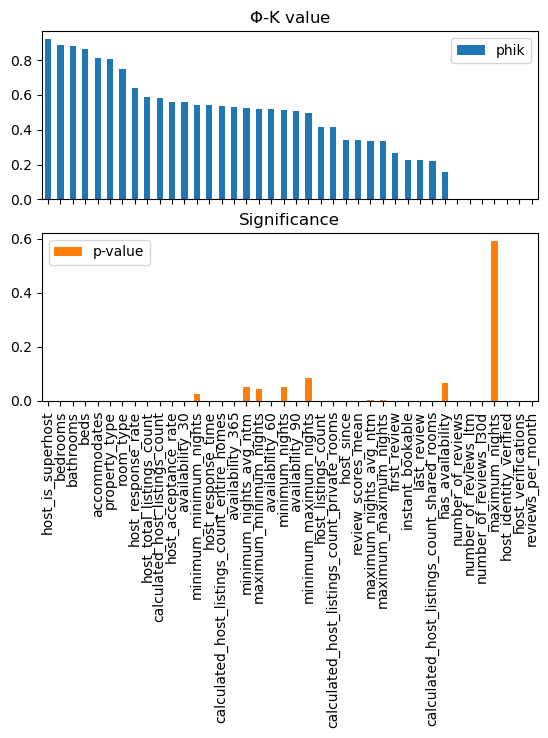

In [16]:
df_phik_price.iloc[1:].plot.bar(subplots=True, title=[r'$\Phi$-K value', 'Significance'])

We might consider throwing out variables with correlations weaker than 0.2. But let's also take into account the correlations between the variables.

## Pearson correlation between all features

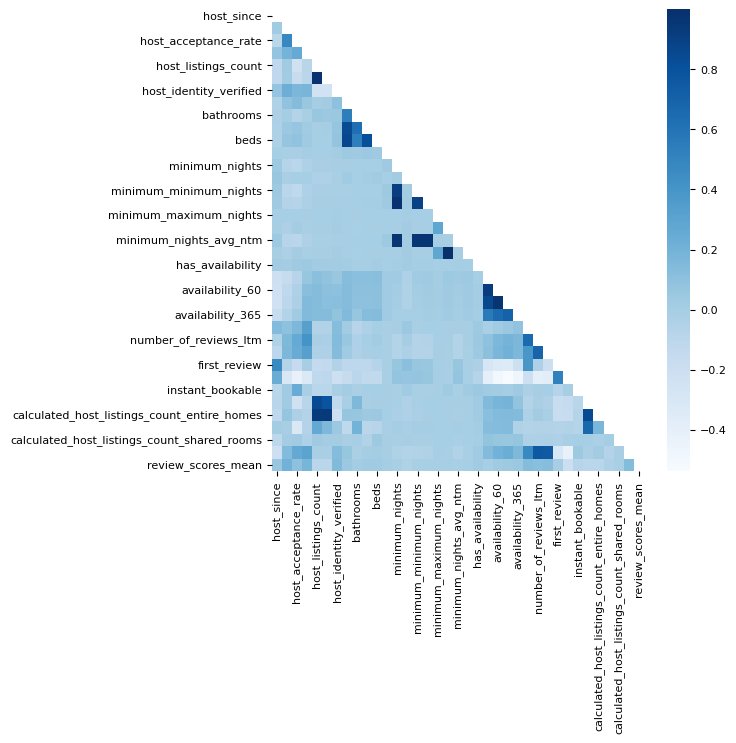

In [17]:
matrix = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(matrix,
            mask=mask,
#            annot=True,
            ax=ax,
            cmap='Blues',
#            fmt='.2f',
#            annot_kws={'size': 6}
           )
ax.tick_params(labelsize=8)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

The heatmap shows some strong and very strong Pearson correlations in dark blue. Let's examine all the correlations above a threshold of 0.6.

In [18]:
# Create a dataframe out of the Pearson correlations
df_corr = df.select_dtypes(include=np.number).corr().stack().reset_index()
# Rename the columns of the correlation dataframe
df_corr = df_corr.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})
# Filter out correlations between the same features
df_corr = df_corr[df_corr['feature_1'] != df_corr['feature_2']]
# Filter the correlations that have a correlation value greater than 0.8
df_corr[df_corr.correlation > 0.6]

feature_1  \
153                            host_listings_count   
179                            host_listings_count   
180                            host_listings_count   
189                      host_total_listings_count   
216                      host_total_listings_count   
217                      host_total_listings_count   
268                                   accommodates   
269                                   accommodates   
305                                      bathrooms   
340                                       bedrooms   
341                                       bedrooms   
343                                       bedrooms   
377                                           beds   
379                                           beds   
458                                 minimum_nights   
459                                 minimum_nights   
462                                 minimum_nights   
530                         minimum_minimum_nights   
533                         minimum_minimum_nights   
536                         minimum_minimum_nights   
567                         maximum_minimum_nights   
569                         maximum_minimum_nights   
573                         maximum_minimum_nights   
648                         maximum_maximum_nights   
678                         minimum_nights_avg_ntm   
680                         minimum_nights_avg_ntm   
681                         minimum_nights_avg_ntm   
720                         maximum_nights_avg_ntm   
799                                availability_30   
800                                availability_30   
835                                availability_60   
837                                availability_60   
838                                availability_60   
872                                availability_90   
873                                availability_90   
875                                availability_90   
910                               availability_365   
911                               availability_365   
951                              number_of_reviews   
987                          number_of_reviews_ltm   
989                          number_of_reviews_ltm   
997                          number_of_reviews_ltm   
1025                        number_of_reviews_l30d   
1034                        number_of_reviews_l30d   
1151                calculated_host_listings_count   
1152                calculated_host_listings_count   
1179                calculated_host_listings_count   
1180                calculated_host_listings_count   
1188   calculated_host_listings_count_entire_homes   
1189   calculated_host_listings_count_entire_homes   
1215   calculated_host_listings_count_entire_homes   
1252  calculated_host_listings_count_private_rooms   
1321                             reviews_per_month   
1322                             reviews_per_month   

                                         feature_2  correlation  
153                      host_total_listings_count     0.979759  
179                 calculated_host_listings_count     0.843922  
180    calculated_host_listings_count_entire_homes     0.929996  
189                            host_listings_count     0.979759  
216                 calculated_host_listings_count     0.794056  
217    calculated_host_listings_count_entire_homes     0.939651  
268                                       bedrooms     0.841339  
269                                           beds     0.865045  
305                                       bedrooms     0.625171  
340                                   accommodates     0.841339  
341                                      bathrooms     0.625171  
343                                           beds     0.818930  
377                                   accommodates     0.865045  
379                                       bedrooms     0.818930  
458                         minimum_minimum_nights     0.910381  
459           

The table gives hints as to which features should be dropped, transformed or engineered in some way.

## ϕk-Correlation between all features
ϕk is a measure of the correlation between variables. Here we examine how the features are correlated and then look at the significances. In case of a strong correlation, i.e. close to 1 and a significance below and an alpha of 0.05, we consider dropping more features.

In [19]:
# Calculate phi-k matrix, numerical features are passed
phik_matrix = phik.phik_matrix(df, interval_cols=num_vars)
# Get the significance matrix expressed as one-sided Z
# of the hypothesis test of each variable-pair dependency
sig_matrix = phik.significance_matrix(df, interval_cols=num_vars)

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/phik/significance.py:278: UserWarning: Too few unique values for variable host_response_rate (10) or maximum_nights (1) to calculate significance
  warnings.warn('Too few unique values for variable {0:s} ({1:d}) or {2:s} ({3:d}) to calculate significance'
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/phik/significance.py:278: UserWarning: Too few unique values for variable host_acceptance_rate (10) or maximum_nights (1) to calculate significance
  warnings.warn('Too few unique values for variable {0:s} ({1:d}) or {2:s} ({3:d}) to calculate significance'


The threshold of a p-value of 0.05, i.e. a 95% confidence level, corresponds to Z = 1.64 which is the result of the significance_matrix of the Phik-package ([M. Baak et al. 2019](https://arxiv.org/pdf/1811.11440.pdf)). We use this characteristic to mask statistically insignificant ϕk correlations in a heat map. 

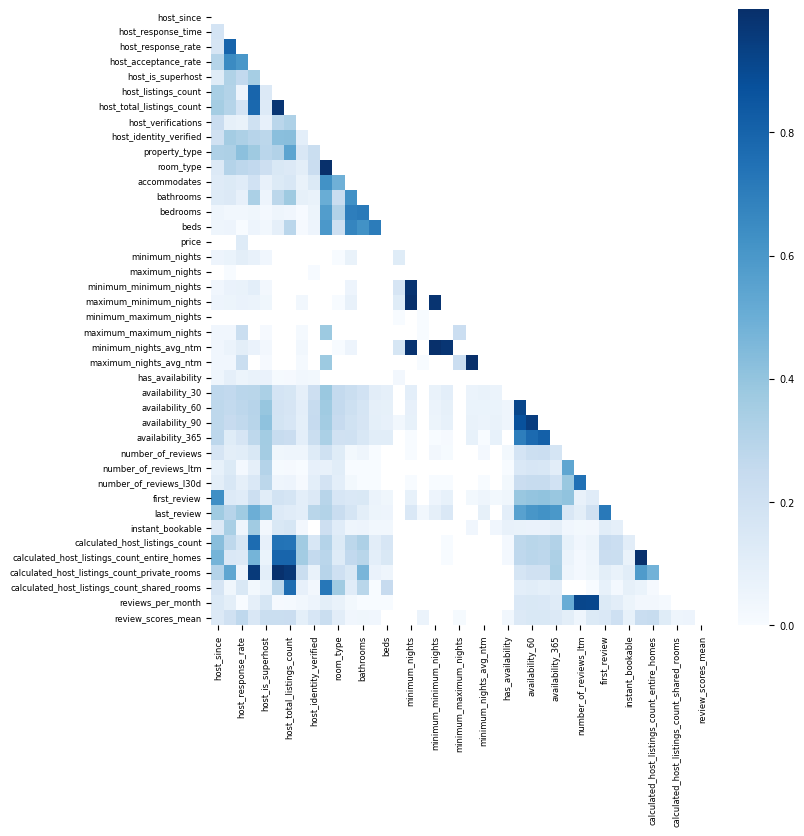

In [20]:
# Create a mask above the diagonal due to the symmetry of the matrix
mask = np.triu(np.ones_like(sig_matrix, dtype=bool))
# Add a mask for a significance for alpha<0.05, i.e. z-score>1.96
mask = (sig_matrix<1.64) | mask

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(phik_matrix,
            mask=mask,
#            annot=True,
            ax=ax,
            cmap='Blues',
#            fmt='.2f',
#            annot_kws={'size': 6}
           )
ax.tick_params(labelsize=6)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=7)

In [21]:
# Create a mask for phik larger than 0.6 and z-score > 1.96
mask_phik_sig = np.logical_and(~mask.values, # inverse heatmap mask
                               phik_matrix > 0.6,
                               sig_matrix > 1.64)

# Mask the phik_matrix, unstack, reset its index and dropna
df_phik_z = phik_matrix[mask_phik_sig].unstack().reset_index().dropna()
df_phik_z = df_phik_z.rename(columns={'level_0':'feature_1', 'level_1':'feature_2', 0:'phik'})
df_phik_z = df_phik_z.sort_values(by='phik', ascending=False).reset_index(drop=True)

# Iterate over df_phik_z and add z-score from significance matrix
for idx, (x, y) in enumerate(zip(df_phik_z['feature_1'], df_phik_z['feature_2'])):
    df_phik_z.loc[idx, 'z_score'] = sig_matrix.loc[x, y]

df_phik_z

feature_1  \
0                   minimum_nights   
1           minimum_minimum_nights   
2                    property_type   
3           maximum_maximum_nights   
4   calculated_host_listings_count   
5              host_listings_count   
6                   minimum_nights   
7                   minimum_nights   
8           minimum_minimum_nights   
9              host_listings_count   
10          maximum_minimum_nights   
11       host_total_listings_count   
12            host_acceptance_rate   
13                 availability_60   
14                 availability_30   
15           number_of_reviews_ltm   
16          number_of_reviews_l30d   
17                 availability_30   
18                 availability_90   
19              host_response_time   
20       host_total_listings_count   
21             host_listings_count   
22            host_acceptance_rate   
23            host_acceptance_rate   
24                 availability_60   
25       host_total_listings_count   
26            host_acceptance_rate   
27           number_of_reviews_ltm   
28             host_listings_count   
29       host_total_listings_count   
30                   property_type   
31                    first_review   
32                       bathrooms   
33                        bedrooms   
34                 availability_30   
35                    accommodates   
36                    accommodates   
37              host_response_time   
38                      host_since   
39                    accommodates   
40                   property_type   
41                 availability_90   
42                       bathrooms   
43                 availability_60   
44              host_response_rate   

                                       feature_2      phik     z_score  
0                         maximum_minimum_nights  0.999503   38.944774  
1                         minimum_nights_avg_ntm  0.999381   36.976259  
2                                      room_type  0.998706  161.451635  
3                         maximum_nights_avg_ntm  0.997859   14.057225  
4    calculated_host_listings_count_entire_homes  0.995279  136.043716  
5   calculated_host_listings_count_private_rooms  0.992245   52.169925  
6                         minimum_minimum_nights  0.987787   36.819117  
7                         minimum_nights_avg_ntm  0.985133   38.681170  
8                         maximum_minimum_nights  0.980998   36.763709  
9                      host_total_listings_count  0.979115   85.878984  
10                        minimum_nights_avg_ntm  0.977811   38.603320  
11  calculated_host_listings_count_private_rooms  0.966908   50.075335  
12  calculated_host_listings_count_private_rooms  0.959742   47.452505  
13                               availability_90  0.946606  228.615920  
14                               availability_60  0.914619  200.293273  
15                             reviews_per_month  0.914107   44.911325  
16                             reviews_per_month  0.913014   54.530121  
17                               availability_90  0.871974  181.786805  
18                              availability_365  0.813488  168.420564  
19                            host_response_rate  0.797400   65.936591  
20   calculated_host_listings_count_entire_homes  0.794978   76.223393  
21   calculated_host_listings_count_entire_homes  0.794700   76.151731  
22                           host_listings_count  0.794432   47.995981  
23                     host_total_listings_count  0.782578   47.474769  
24                              availability_365  0.774086  151.654766  
25   calculated_host_listings_count_shared_rooms  0.768494   17.991396  
26                calculated_host_listings_count  0.768453   53.126633  
27                        number_of_reviews_l30d  0.748989   48.581445  
28                calculated_host_listings_count  0.738938   77.928529  
29                calculated_host_listings_count  0.735516   78.010800  
30   calculat

## Engineer total capacity feature
*accommodates*, *beds* and *bedrooms* are highly correlated. Let's engineer *total_capacity* as their sum.

In [22]:
df['total_capacity'] = df['accommodates'] + df['beds'] + df['bedrooms']
df.drop(columns=['accommodates', 'beds', 'bedrooms'], inplace=True)

## Drop *property_type*
There is a strong correlation between *property_type* and *room_type*. As property_type is much more specific and is chosen by the host, 15 property types exist only once and even more only a few times. Let'drop *property_type*!

In [23]:
df.drop(columns='property_type', inplace=True)

## Drop *host_response_time*
*host_response_rate* and *host_response_time* are highly correlated. Of the two, it seems to be more important whether a host responds, rather than how quickly. Let's drop *host_response_time*.

In [24]:
df.drop(columns='host_response_time', inplace=True)

## Drop counting features

In [25]:
df.drop(columns=[col for col in df.columns if 'count' in col], inplace=True)

## Drop min/max night features
The features regarding mininum or maximum nights are highly correlated an hold no valuable information. Let's drop them.

In [26]:
df.drop(columns=[col for col in df.columns if 'night' in col], inplace=True)

## Drop availability features
The features concerning *availabilty* are highly correlated and hold no valuable information. Let's drop them.

In [27]:
df.drop(columns=[col for col in df.columns if 'availability' in col], inplace=True)

## Drop review counts

In [28]:
df.drop(columns=['number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review',
                 'reviews_per_month'], inplace=True)

In [29]:
df_corr = df.select_dtypes(include=np.number).corr().stack().reset_index()
df_corr = df_corr.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})
df_corr = df_corr[df_corr['feature_1'] != df_corr['feature_2']]

df_corr.sort_values(by='correlation', ascending=False).head(5)

feature_1             feature_2  correlation
65              bathrooms        total_capacity     0.584274
115        total_capacity             bathrooms     0.584274
23   host_acceptance_rate    host_response_rate     0.484324
13     host_response_rate  host_acceptance_rate     0.484324
80      number_of_reviews     host_is_superhost     0.326280

In [30]:
df_corr.sort_values(by='correlation', ascending=True).head(5)

feature_1             feature_2  correlation
88      instant_bookable            host_since    -0.097100
8             host_since      instant_bookable    -0.097100
2             host_since  host_acceptance_rate    -0.093177
22  host_acceptance_rate            host_since    -0.093177
62             bathrooms     number_of_reviews    -0.080080

<Axes: >

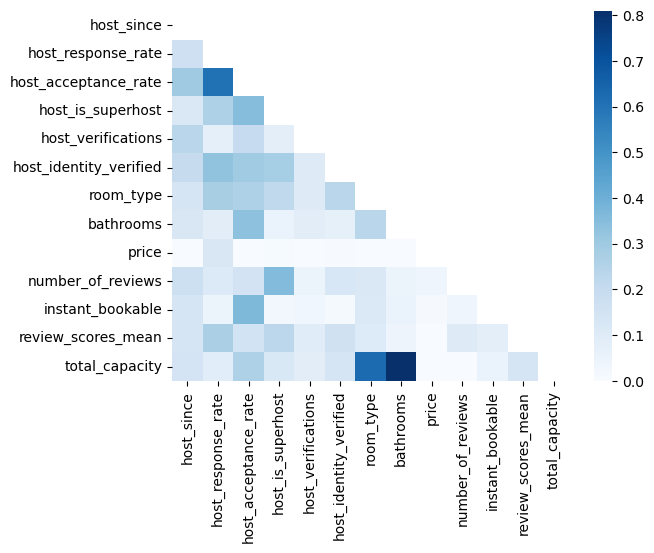

In [31]:
phik_check = phik.phik_matrix(df, interval_cols=num_vars)
mask = np.triu(np.ones_like(phik_check, dtype=bool))
sns.heatmap(phik_check, mask=mask, cmap='Blues')

After extensive correlation analysis, we are left with 13 features in the dataset, one of which is price.

## Variance thresholding

In [32]:
# Create a VarianceThreshold object with a threshold of 0.03
vt = VarianceThreshold(threshold=0.03)
# Select the numerical columns from the DataFrame
df_var = df.select_dtypes(include=np.number)
# Normalize the numerical columns by dividing by their mean
df_var_norm = df_var / df_var.mean()
# Fit the VarianceThreshold to the normalized data
_ = vt.fit(df_var_norm)
# Get the mask of low-variance features (features with variance below the threshold)
mask = ~vt.get_support()
# Get the column names of the low-variance features
df_var.columns[mask]

Index(['review_scores_mean'], dtype='object')

The mean of the review scores has low variance and thus holds little information. The feature could also be dropped.

In [33]:
df.drop(columns='review_scores_mean', inplace=True)

## Examine missing values

In [34]:
round(df.isna().sum()/len(df)*100,2)

host_since                 0.01
host_response_rate        34.33
host_acceptance_rate      30.65
host_is_superhost          0.04
host_verifications         0.01
host_identity_verified     0.01
room_type                  0.00
bathrooms                  0.06
price                      0.00
number_of_reviews          0.00
instant_bookable           0.00
total_capacity             4.29
dtype: float64

## Impute missing data with mean

In [35]:
import numpy as np
from sklearn.impute import SimpleImputer

# Create a SimpleImputer object with strategy='mean'
imputer = SimpleImputer(strategy='mean')

# Select only the numerical columns from the DataFrame
numerical_columns = df.select_dtypes(include=np.number).columns

# Fit and transform the numerical columns
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

## Drop remaining missing rows

In [36]:
df.isna().sum()

host_since                0
host_response_rate        0
host_acceptance_rate      0
host_is_superhost         0
host_verifications        2
host_identity_verified    0
room_type                 0
bathrooms                 0
price                     0
number_of_reviews         0
instant_bookable          0
total_capacity            0
dtype: int64

In [37]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

## Encode categoricals numerically

In [38]:
dict_room_type = {key: idx for idx, key in enumerate(sorted(df.room_type.unique()))}
df.loc[:,'room_type'] = df.loc[:,'room_type'].map(dict_room_type)

dict_host_verifications = {key: idx for idx, key in enumerate(sorted(df.host_verifications.unique()))}
df.loc[:,'host_verifications'] = df.loc[:,'host_verifications'].map(dict_host_verifications)
df.loc[:,'host_verifications'] = df.loc[:,'host_verifications'].astype(int).astype('category')

## Handling outliers in target with mean absolute deviation

(array([2.0558e+04, 1.2900e+02, 2.5000e+01, 1.9000e+01, 3.0000e+00,
        2.0000e+00, 8.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

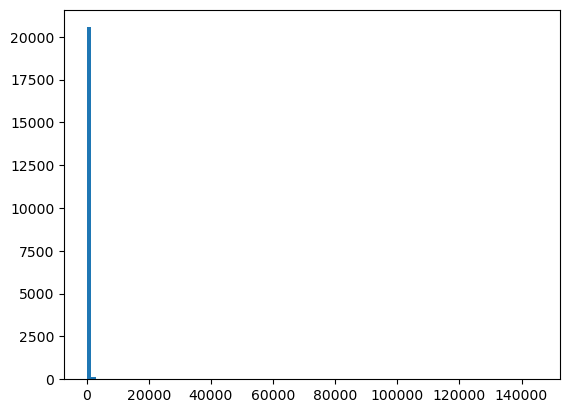

In [39]:
# Plot histogram of target variable
plt.hist(df['price'], bins=100)

In [40]:
# Get descriptive statistics
df['price'].describe()

count     20766.000000
mean        289.806655
std        2446.642422
min           0.000000
25%          99.000000
50%         160.000000
75%         250.000000
max      145160.000000
Name: price, dtype: float64

The histogram and descriptive statistics show that there must be outliers in the target feature. As the feature is not normally distributed, we use the mean absolute deviation to identify outliers and remove them from the data set.

In [41]:
from pyod.models.mad import MAD

# Reshape the target to make it 2D
y_2d = df['price'].values.reshape(-1,1)
# Fit the mean absoulte deviation to the target
mad = MAD().fit(y_2d)

# Extract the inlier/outlier labels
labels = mad.labels_
labels

array([0, 0, 0, ..., 0, 1, 0])

In [42]:
outliers_y_mad = df['price'].values[labels == 1]

num_outliers = len(outliers_y_mad)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(df['price']):.3f}")

The number of outliers: 1259
Percentage of outliers: 0.061


(array([1.00e+00, 5.00e+01, 2.56e+02, 5.38e+02, 7.64e+02, 8.02e+02,
        8.67e+02, 8.20e+02, 9.75e+02, 9.28e+02, 7.59e+02, 7.96e+02,
        7.92e+02, 8.12e+02, 1.07e+03, 7.81e+02, 7.80e+02, 7.98e+02,
        8.33e+02, 5.14e+02, 5.11e+02, 4.71e+02, 3.25e+02, 5.33e+02,
        2.44e+02, 2.66e+02, 3.02e+02, 2.30e+02, 4.14e+02, 1.69e+02,
        1.45e+02, 1.61e+02, 1.31e+02, 2.42e+02, 1.12e+02, 1.64e+02,
        8.20e+01, 1.81e+02, 9.20e+01, 8.00e+01, 7.40e+01, 7.50e+01,
        1.06e+02, 5.40e+01, 6.20e+01, 5.80e+01, 5.80e+01, 1.34e+02,
        4.90e+01, 4.60e+01]),
 array([  0.  ,  10.56,  21.12,  31.68,  42.24,  52.8 ,  63.36,  73.92,
         84.48,  95.04, 105.6 , 116.16, 126.72, 137.28, 147.84, 158.4 ,
        168.96, 179.52, 190.08, 200.64, 211.2 , 221.76, 232.32, 242.88,
        253.44, 264.  , 274.56, 285.12, 295.68, 306.24, 316.8 , 327.36,
        337.92, 348.48, 359.04, 369.6 , 380.16, 390.72, 401.28, 411.84,
        422.4 , 432.96, 443.52, 454.08, 464.64, 475.2 , 485.76, 49

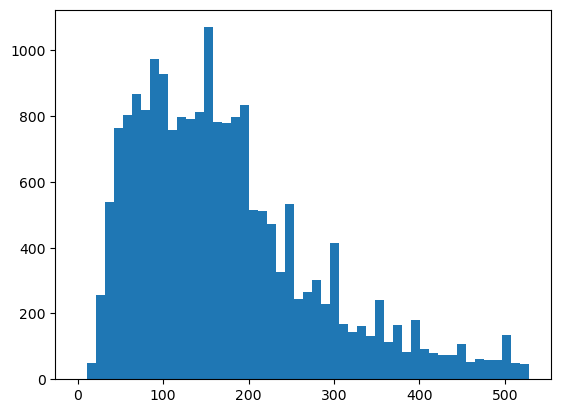

In [43]:
# Delete outliers from the dataset
df = df[labels==0]
# Plot a histogram of the price again
plt.hist(df['price'], bins=50)

The histogram looks much better now.

In [44]:
## for best result with LGBM
#import pickle
#with open('df_reduced.pkl', 'wb') as file:
#    pickle.dump(df, file)

## Visually inspect skew of features

In [45]:
numeric_columns = df.select_dtypes(include=np.number).columns
# Get non-binary numerical features
non_binary_columns = [col for col in numeric_columns if df[col].nunique() > 2]
non_binary_columns

['host_since',
 'host_response_rate',
 'host_acceptance_rate',
 'bathrooms',
 'price',
 'number_of_reviews',
 'total_capacity']

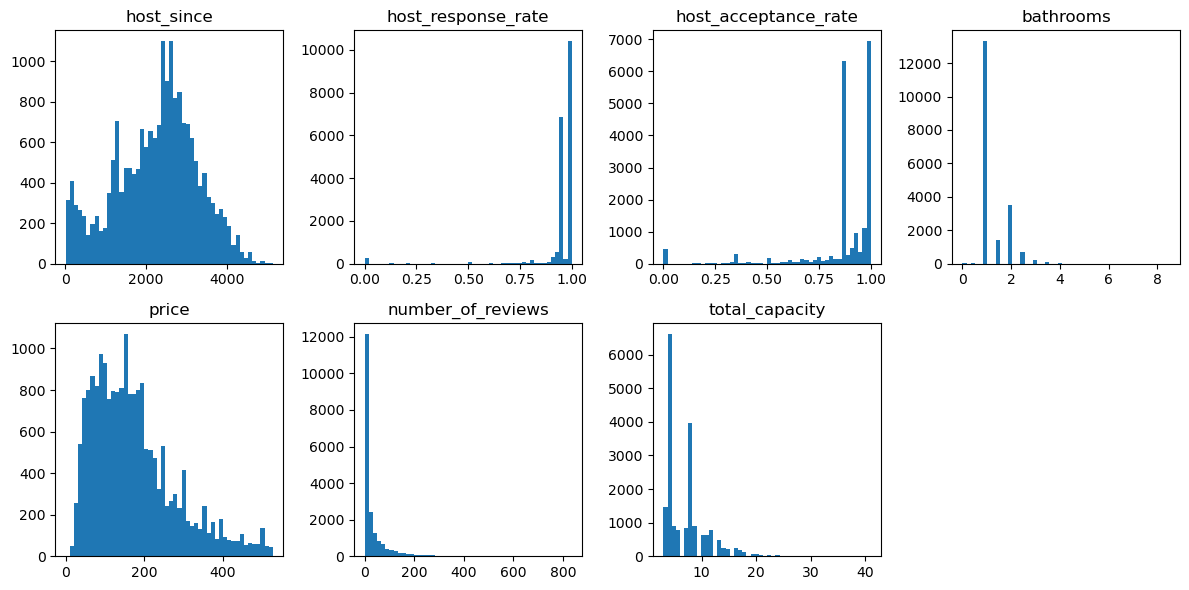

In [46]:
len_num_cols = len(non_binary_columns)
cols = 4
rows = (len_num_cols - 1) // cols + 1

fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

for i, col in enumerate(non_binary_columns):
    ii, ij = i // cols, i % cols
    ax[ii, ij].hist(df[col], bins=50)
    ax[ii, ij].set_title(col)

# Remove empty subplots
if len_num_cols % cols != 0:
    for j in range(len_num_cols % cols, cols):
        fig.delaxes(ax[rows - 1, j])

plt.tight_layout()
plt.show()

## Yeo-Johnson / Box-Cox transform skewed features
Box-Cox only works with positive input values, whereas Yeo-Johnson can work with negative values. 

In [47]:
# Inspect skewness of non-binary numeric features
df[non_binary_columns].skew()

host_since             -0.266197
host_response_rate     -5.780567
host_acceptance_rate   -2.864516
bathrooms               2.770608
price                   1.041804
number_of_reviews       3.907498
total_capacity          1.899945
dtype: float64

In [48]:
len(non_binary_columns)

7

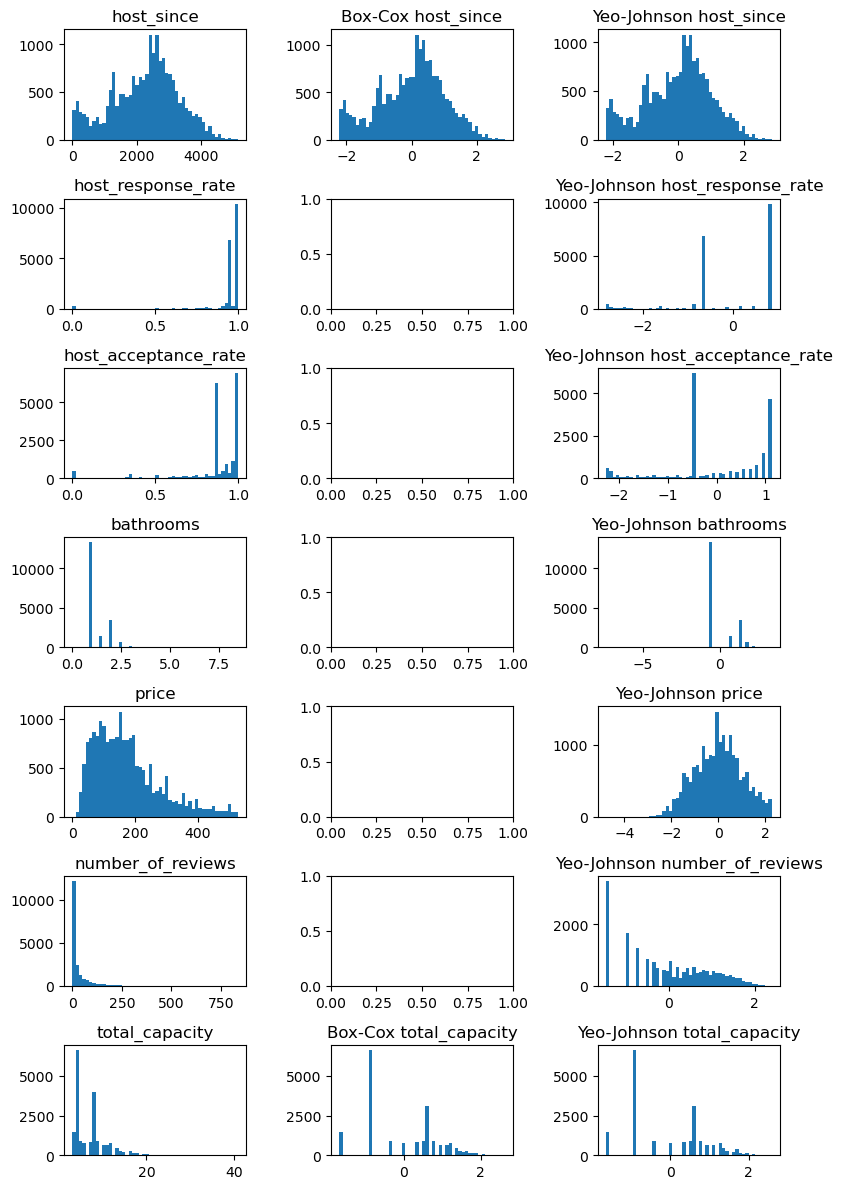

In [49]:
pt = PowerTransformer()

fig, ax = plt.subplots(len(non_binary_columns), 3, figsize=(8, 12))

df_skew = pd.DataFrame({'skew': df[non_binary_columns].skew()})

for i, col in enumerate(non_binary_columns):
    ax[i, 0].hist(df[col], bins=50)
    ax[i, 0].set_title(col)

    # Transform with Box-Cox for purely positive features
    if all(x > 0 for x in df[col]):
        pt.set_params(method='box-cox')

        data = pt.fit_transform(df[col].values.reshape(-1, 1))
        df_skew.loc[col, 'skew_box_cox'] = skew(data)

        ax[i, 1].hist(data, bins=50)
        ax[i, 1].set_title('Box-Cox '+col)

    # Transform with Yeo-Johnson
    pt.set_params(method='yeo-johnson')

    data = pt.fit_transform(df[col].values.reshape(-1, 1))
    df_skew.loc[col, 'skew_yeo_johnson'] = skew(data)

    ax[i, 2].hist(data, bins=50)
    ax[i, 2].set_title('Yeo-Johnson '+col)

plt.tight_layout()
plt.show()

In [50]:
df_skew

skew  skew_box_cox  skew_yeo_johnson
host_since           -0.266197     -0.259075         -0.258034
host_response_rate   -5.780567           NaN         -0.910055
host_acceptance_rate -2.864516           NaN         -0.554357
bathrooms             2.770608           NaN         -0.341585
price                 1.041804           NaN         -0.021853
number_of_reviews     3.907498           NaN          0.043838
total_capacity        1.899945      0.088609          0.109492

In [51]:
df_skew.loc[:, 'box_cox_better'] = (np.abs(df_skew['skew'])-np.abs(0-df_skew.skew_box_cox))>0
df_skew.loc[:, 'yeo_johnson_better'] = (np.abs(df_skew['skew'])-np.abs(0-df_skew.skew_yeo_johnson))>0
df_skew

skew  skew_box_cox  skew_yeo_johnson  \
host_since           -0.266197     -0.259075         -0.258034   
host_response_rate   -5.780567           NaN         -0.910055   
host_acceptance_rate -2.864516           NaN         -0.554357   
bathrooms             2.770608           NaN         -0.341585   
price                 1.041804           NaN         -0.021853   
number_of_reviews     3.907498           NaN          0.043838   
total_capacity        1.899945      0.088609          0.109492   

                      box_cox_better  yeo_johnson_better  
host_since                      True                True  
host_response_rate             False                True  
host_acceptance_rate           False                True  
bathrooms                      False                True  
price                          False                True  
number_of_reviews              False                True  
total_capacity                  True                True

In all cases except the *host_since* feature, the power transformation reduces the skewness of the data. In some cases the Box-Cox methods give slightly better skew than Yeo-Johnson. Let's fit_transform the data in the data frame.

In [52]:
# non_binary_columns without total_capacity
cols_yeo_johnson = sorted([item for item in non_binary_columns if item != 'total_capacity'])
cols_box_cox = ['total_capacity']

for col in cols_box_cox:
    pt.set_params(method='box-cox')
    df[col] = pt.fit_transform(df[col].values.reshape(-1,1))

for col in cols_yeo_johnson:
    pt.set_params(method='yeo-johnson')
    df[col] = pt.fit_transform(df[col].values.reshape(-1,1))

In [53]:
# Save the PowerTransformer object as a pickle file
with open('power_transformer.pkl', 'wb') as f:
    pickle.dump(pt, f)

NameError: name 'pickle' is not defined

## Encode categoricals numerically

In [ ]:
# ggf. weglassen
dict_room_type = {key: idx for idx, key in enumerate(sorted(df.room_type.unique()))}
df.loc[:,'room_type'] = df.loc[:,'room_type'].map(dict_room_type)

dict_host_verifications = {key: idx for idx, key in enumerate(sorted(df.host_verifications.unique()))}
df.loc[:,'host_verifications'] = df.loc[:,'host_verifications'].map(dict_host_verifications)
df.loc[:,'host_verifications'] = df.loc[:,'host_verifications'].astype(int).astype('category')

In [63]:
# Get the categorical features
cols_categorical = df.select_dtypes(include='category').columns.to_list()

# Create an instance of OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

# Fit and transform the selected columns
encoded_data = ohe.fit_transform(df[cols_categorical])

# Create a DataFrame with the encoded data
df_encoded = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(cols_categorical))

# Reset indices to avoid problems when concatenating
df.reset_index(drop=True, inplace=True)

# Concatenate the encoded DataFrame with the original DataFrame
df = pd.concat([df, df_encoded], axis=1)

In [64]:
# Drop the original categorical columns
df.drop(columns=cols_categorical, inplace=True)

## Scale the data

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# leave target untouched
target = df['price'].reset_index(drop=True)
arr_scaled = scaler.fit_transform(df.drop(columns='price'))

df_scaled = pd.DataFrame(arr_scaled, columns=df.drop(columns='price').columns)
df_scaled['price']=target

## Dump dataframe as pickle

In [ ]:
with open('df_latest.pkl', 'wb') as f:
    pickle.dump(df, f)

## Test multiple models

In [83]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'),
                                                    df['price'],
                                                    test_size=0.2,
                                                    random_state=42)

# Inverse transform y_test
y_test = pt.inverse_transform(y_test.values.reshape(-1, 1))

models = [
    BayesianRidge(),
    ElasticNet(),
    GradientBoostingRegressor(),
    LGBMRegressor(),
    LinearRegression(),
    RandomForestRegressor(),
    SGDRegressor(),
    XGBRegressor()
              ]

score_dict = {model.__class__.__name__: {'rmse': None, 'mae': None} for model in models}

for model in models:
    model_name = model.__class__.__name__
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Inverse-transform y_pred as well
    y_pred = pt.inverse_transform(y_pred.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    score_dict[model_name]['rmse'] = rmse
    score_dict[model_name]['mae'] = mae

    print(f'{model_name : <25} RMSE: {rmse : .4f}{"":<5} MAE: {mae : .4f}')
    #print(f'{model_name : <25} RMSE: {rmse : .4f}, MAE: {"": <10}{mae : .4f}')


BayesianRidge             RMSE:  81.1351      MAE:  56.9357
ElasticNet                RMSE:  105.3411      MAE:  78.1358
GradientBoostingRegressor RMSE:  74.6935      MAE:  51.3087
LGBMRegressor             RMSE:  71.6521      MAE:  48.6572
LinearRegression          RMSE:  81.1238      MAE:  56.9239
RandomForestRegressor     RMSE:  71.7018      MAE:  48.2095
SGDRegressor              RMSE:  81.2958      MAE:  57.0780
XGBRegressor              RMSE:  71.2767      MAE:  48.0353


## Get top 3 models based on RMSE

In [72]:
# Sort the models based on RMSE values in ascending order
sorted_models = sorted(score_dict.items(), key=lambda x: x[1]['rmse'])
# Extract the lowest three models and their corresponding RMSE values
lowest_three = dict(sorted_models[:3])
# Create a new dictionary containing only the RMSE values of the lowest three models
rmse_dict = {model: values['rmse'] for model, values in lowest_three.items()}

print('sorted for lowest rmse')
rmse_dict

sorted for lowest rmse


{'XGBRegressor': 71.27674696597352,
 'LGBMRegressor': 71.65211191598726,
 'RandomForestRegressor': 71.70395567285999}

## Custom scorer

In [86]:
learning_curve?

In [89]:
# Create a custom scorer with inverse transformation
def inverse_rmse_scorer(y_true, y_pred):
    '''This scorer first inverts both y-values and then scores the RMSE.'''
    y_true_inverse = pt.inverse_transform(y_true.values.reshape(-1, 1))
    y_pred_inverse = pt.inverse_transform(y_pred.reshape(-1, 1))
    # Calculate the score using the inverse transformed predictions and true values
    rmse = np.sqrt(mean_squared_error(y_true_inverse, y_pred_inverse))
    return rmse

# Make the custom scorer
inverse_rmse_scorer = make_scorer(inverse_rmse_scorer)

## Score and plot learning curves of top 3 models

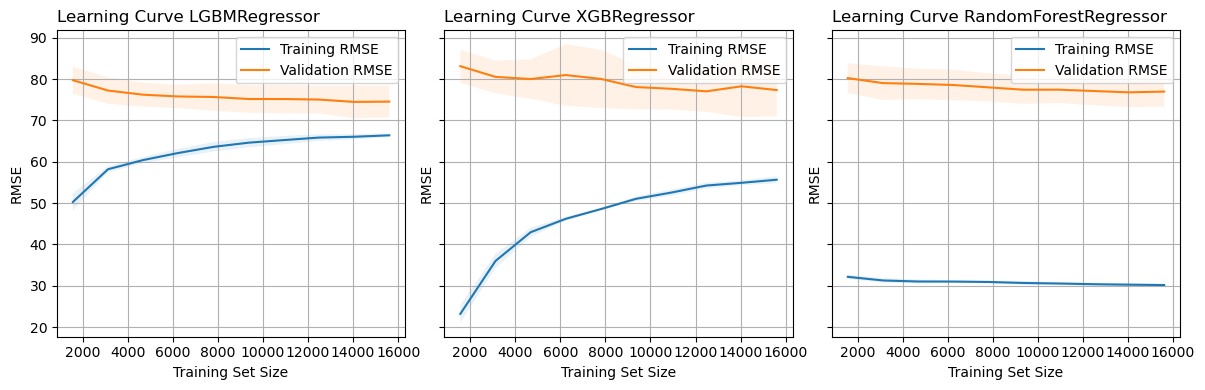

In [90]:
models = [LGBMRegressor(), XGBRegressor(), RandomForestRegressor()]

score_dict = {}

# Arrange the 3 learning curve plots in one row
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    train_sizes = np.linspace(0.1, 1.0, 10)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=df.drop(columns='price'),
        y=df['price'],
        train_sizes=train_sizes,
        cv=5,
        scoring=inverse_rmse_scorer,
        shuffle=True
    )

    # Compute the mean and standard deviation of the scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Save the scores
    score_dict[model_name] = {
        'train sizes': train_sizes,
        'train mean': train_mean,
        'test mean': test_mean,
        'train std': train_std,
        'test std': test_std
        }
   
    # Plot training and validation results
    ax[i].plot(train_sizes, train_mean, label='Training RMSE')
    ax[i].plot(train_sizes, test_mean, label='Validation RMSE')
    ax[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    ax[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    ax[i].set_xlabel('Training Set Size')
    ax[i].set_ylabel('RMSE')
    ax[i].set_title(f'Learning Curve {model_name}', loc='left')
    ax[i].legend(loc='best')
    ax[i].grid(True)

plt.tight_layout()
plt.show()

## Tune LGMB with Optuna

In [99]:
import optuna
from sklearn.model_selection import KFold
import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
def objective(trial, X, y):
    
    param_grid = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 200, 10000, step=100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores_rmse = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
                   
        model = LGBMRegressor(**param_grid)
        
        # Create dataset for LightGBM
        lgb_train = lgbm.Dataset(X_train, y_train)
        lgb_eval = lgbm.Dataset(X_test, y_test, reference=lgb_train)
        
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
                  callbacks=[LightGBMPruningCallback(trial, 'rmse'),
                             lgbm.early_stopping(50)])

        y_pred = model.predict(X_test)
        
        # Inverse transform before scoring due to previous PowerTransformation
        y_test, y_pred = pt.inverse_transform(y_test.values.reshape(-1,1)), pt.inverse_transform(y_pred.reshape(-1,1))
        
        # Calculate the root mean squared error
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        cv_scores_rmse[idx] = rmse

    return np.mean(cv_scores_rmse)

study = optuna.create_study(direction='minimize', study_name="LGBM Regressor")
func = lambda trial: objective(trial, df.drop(columns='price'), df['price'])
study.optimize(func, n_trials=100, show_progress_bar=True)

[I 2023-07-11 14:35:41,272] A new study created in memory with name: LGBM Regressor
  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=7.212853148701698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.212853148701698
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 0.657053
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 0. Best value: 78.1392:   1%|       | 1/100 [00:00<00:46,  2.11it/s]

Early stopping, best iteration is:
[34]	valid_0's rmse: 0.672151
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=7.212853148701698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.212853148701698
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.655118
[LightGBM] [Warning] min_data_in_leaf is set=900, min_chi

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 0.821418
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.717374019675971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.717374019675971
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 0.8

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.

Best trial: 0. Best value: 78.1392:   2%|▏      | 2/100 [00:00<00:39,  2.49it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 0.811028
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.717374019675971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.717374019675971
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 0.8

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 0. Best value: 78.1392:   3%|▏      | 3/100 [00:00<00:26,  3.71it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already

[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.2337812045568572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2337812045568572
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.990124
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] lambda

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[88]	valid_0's rmse: 0.692793
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=6.577023276778162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.577023276778162
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's rmse: 0.693539
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 0. Best value: 78.1392:   4%|▎      | 4/100 [00:01<00:41,  2.29it/s]

Early stopping, best iteration is:
[130]	valid_0's rmse: 0.676552
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=6.577023276778162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.577023276778162
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's rmse: 0.659524
[I 2023-07-11 14:35:42,903] Trial 3 finished with valu

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[64]	valid_0's rmse: 0.781003
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=4.464765248512846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.464765248512846
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 0.793389
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_tria

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[63]	valid_0's rmse: 0.777231
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=4.464765248512846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.464765248512846
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 0.774789
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 0. Best value: 78.1392:   5%|▎      | 5/100 [00:02<00:44,  2.13it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[63]	valid_0's rmse: 0.768895
[I 2023-07-11 14:35:43,428] Trial 4 finished with value: 87.43508618643693 and parameters: {'n_estimators': 5200, 'learning_rate': 0.11609340732786168, 'num_leaves': 1680, 'max_depth': 12, 'min_data_in_leaf': 4800, 'max_bin': 200, 'lambda_l1': 0, 'lambda_l2': 20, 'min_gain_to_split': 4.464765248512846, 'bagging_fraction': 0.2, 'feature_fraction': 0.7}. Best is trial 0 with value: 78.13921181552432.
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 0.703281
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.749079909944129, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.749079909944129
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

Best trial: 0. Best value: 78.1392:   6%|▍      | 6/100 [00:02<00:44,  2.09it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 0. Best value: 78.1392:   6%|▍      | 6/100 [00:02<00:44,  2.09it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 0. Best value: 78.1392:   7%|▍      | 7/100 [00:02<00:44,  2.09it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1,

Early stopping, best iteration is:
[41]	valid_0's rmse: 0.688641
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.749079909944129, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.749079909944129
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 0.673958
[I 2023-07-11 14:35:43,923] Trial 5 finished with value

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[27]	valid_0's rmse: 0.687883
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.545451779737398, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.545451779737398
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.704375
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignor

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[31]	valid_0's rmse: 0.684812
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=9.545451779737398, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.545451779737398
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.675301
[I 2023-07-11 14:35:44,406] Trial 10 finished with value: 80.9819540168113 and parame

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=5.757857807905563, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.757857807905563
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.679765
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 0. Best value: 78.1392:  12%|▋     | 12/100 [00:03<00:22,  3.94it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[25]	valid_0's rmse: 0.658247
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=5.757857807905563, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.757857807905563
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.646308
[I 2023-07-11 14:35:44,890] Trial 11 finished with value: 7

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[28]	valid_0's rmse: 0.655304
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=4.571219269965307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.571219269965307
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.674613
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. C

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 12. Best value: 78.0778:  13%|▋    | 13/100 [00:04<00:26,  3.32it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 12. Best value: 78.0778:  13%|▋    | 13/100 [00:04<00:26,  3.32it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 12. Best value: 78.0778:  14%|▋    | 14/100 [00:04<00:25,  3.32it/s]

Early stopping, best iteration is:
[29]	valid_0's rmse: 0.654757
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=4.571219269965307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.571219269965307
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.640032
[I 2023-07-11 14:35:45,385] Trial 12 finished with value: 78.07777726754566 and parameter

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 12. Best value: 78.0778:  16%|▊    | 16/100 [00:04<00:15,  5.47it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[I 2023-07-11 14:35:45,506] Trial 15 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.660648
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=2.706034689158696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.706034689158696
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[31]	valid_0's rmse: 0.678982
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=2.706034689158696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.706034689158696
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.6723
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 16. Best value: 78.0743:  16%|▊    | 16/100 [00:04<00:15,  5.47it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.644033
[I 2023-07-11 14:35:45,996] Trial 16 finished with value: 78.07425179211118 and parameters: {'n_estimators': 2800, 'learning_rate': 0.18765508165315245, 'num_leaves': 1840, 'max_depth': 7, 'min_data_in_leaf': 1500, 'max_bin': 276, 'lambda_l1': 55, 'lambda_l2': 60, 'min_gain_to_split': 2.706034689158696, 'bagging_fraction': 0.5, 'feature_fraction': 0.9}. Best is trial 16 with value: 78.07425179211118.
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 0.685061
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.6190105887325483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6190105887325483
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.6

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 16. Best value: 78.0743:  18%|▉    | 18/100 [00:05<00:22,  3.69it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  18%|▉    | 18/100 [00:05<00:22,  3.69it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  20%|█    | 20/100 [00:05<00:16,  4.89it/s]

Early stopping, best iteration is:
[32]	valid_0's rmse: 0.663453
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.6190105887325483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6190105887325483
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 0.649824
[I 2023-07-11 14:35:46,457] Trial 17 finished with valu

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  20%|█    | 20/100 [00:05<00:16,  4.89it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  21%|█    | 21/100 [00:05<00:16,  4.89it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  

[I 2023-07-11 14:35:46,602] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2023-07-11 14:35:46,645] Trial 21 pruned. Trial was pruned at iteration 0.
[I 2023-07-11 14:35:46,687] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2023-07-11 14:35:46,730] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2023-07-11 14:35:46,773] Trial 24 pruned. Trial was pruned at iteration 0.


Best trial: 16. Best value: 78.0743:  26%|█▎   | 26/100 [00:05<00:07,  9.43it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  26%|█▎   | 26/100 [00:05<00:07,  9.43it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  27%|█▎   | 27/100 [00:05<00:07,  9.43it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1,

Training until validation scores don't improve for 50 rounds
[I 2023-07-11 14:35:46,817] Trial 25 pruned. Trial was pruned at iteration 1.
[I 2023-07-11 14:35:46,855] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2023-07-11 14:35:46,899] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-07-11 14:35:46,939] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2023-07-11 14:35:46,981] Trial 29 pruned. Trial was pruned at iteration 0.


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  30%|█▌   | 30/100 [00:05<00:05, 11.92it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[I 2023-07-11 14:35:47,020] Trial 30 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.662268
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=6.311934024006413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.311934024006413
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
Training until validation scores don't improve

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[27]	valid_0's rmse: 0.679583
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=6.311934024006413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.311934024006413
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.674933
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 16. Best value: 78.0743:  32%|█▌   | 32/100 [00:06<00:08,  8.41it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already

Early stopping, best iteration is:
[27]	valid_0's rmse: 0.646884
[I 2023-07-11 14:35:47,513] Trial 31 finished with value: 78.67075440287257 and parameters: {'n_estimators': 2000, 'learning_rate': 0.20619008474169248, 'num_leaves': 1620, 'max_depth': 6, 'min_data_in_leaf': 700, 'max_bin': 258, 'lambda_l1': 90, 'lambda_l2': 55, 'min_gain_to_split': 6.311934024006413, 'bagging_fraction': 0.4, 'feature_fraction': 0.6000000000000001}. Best is trial 16 with value: 78.07425179211118.
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.300000

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[25]	valid_0's rmse: 0.679067
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=5.520096578649691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.520096578649691
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.675543
[LightGBM] [Warning] min_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 16. Best value: 78.0743:  32%|█▌   | 32/100 [00:06<00:08,  8.41it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  34%|█▋   | 34/100 [00:06<00:10,  6.39it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  34%|█▋   | 34/100 [00:06<00:10,  6.39it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1,

Early stopping, best iteration is:
[26]	valid_0's rmse: 0.647147
[I 2023-07-11 14:35:47,996] Trial 32 finished with value: 78.66519615164678 and parameters: {'n_estimators': 2500, 'learning_rate': 0.21079166906334815, 'num_leaves': 2120, 'max_depth': 7, 'min_data_in_leaf': 200, 'max_bin': 257, 'lambda_l1': 100, 'lambda_l2': 45, 'min_gain_to_split': 5.520096578649691, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.6000000000000001}. Best is trial 16 with value: 78.07425179211118.
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_t

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 16. Best value: 78.0743:  36%|█▊   | 36/100 [00:06<00:08,  7.59it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[I 2023-07-11 14:35:48,229] Trial 36 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.65766
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=7.267437952647639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.267437952647639
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
Training until validation scores don't improve for 50 rounds
Early stopping

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.669932
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=7.267437952647639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.267437952647639
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.65703
[LightGBM] [Warning] min_da

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[25]	valid_0's rmse: 0.635064
[I 2023-07-11 14:35:48,666] Trial 37 finished with value: 77.64059124891472 and parameters: {'n_estimators': 800, 'learning_rate': 0.21438180135895227, 'num_leaves': 2180, 'max_depth': 7, 'min_data_in_leaf': 1200, 'max_bin': 289, 'lambda_l1': 10, 'lambda_l2': 70, 'min_gain_to_split': 7.267437952647639, 'bagging_fraction': 0.4, 'feature_fraction': 0.8}. Best is trial 37 with value: 77.64059124891472.
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.462470483310488

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[21]	valid_0's rmse: 0.659925
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=8.12767084193746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.12767084193746
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.678452
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Cur

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[22]	valid_0's rmse: 0.657035
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=8.12767084193746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.12767084193746
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.642832
[I 2023-07-11 14:35:49,240] Trial 41 finished with value: 78.38246968301287 and parameters:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[18]	valid_0's rmse: 0.660227
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=9.980017666726464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.980017666726464
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.678243
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. C

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 37. Best value: 77.6406:  43%|██▏  | 43/100 [00:08<00:08,  6.56it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 37. Best value: 77.6406:  45%|██▎  | 45/100 [00:08<00:09,  5.69it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[17]	valid_0's rmse: 0.657804
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=9.980017666726464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.980017666726464
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.645142
[I 2023-07-11 14:35:49,703] Trial 43 finished with value: 78.5306619414166 and parameters

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[19]	valid_0's rmse: 0.654916
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=7.091332701403684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.091332701403684
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.675094
[LightGBM] [Warning] min_data_in_leaf is set=500, min_chi

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
Best trial: 37. Best value: 77.6406:  46%|██▎  | 46/100 [00:08<00:11,  4.61it/s]/Users/romanwolf/Code/DataScienc

Early stopping, best iteration is:
[22]	valid_0's rmse: 0.654447
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=7.091332701403684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.091332701403684
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.641818
[I 2023-07-11 14:35:50,211] Trial 45 finished with value:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 37. Best value: 77.6406:  49%|██▍  | 49/100 [00:09<00:07,  6.85it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 37. Best value: 77.6406:  49%|██▍  | 49/100 [00:09<00:07,  6.85it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  

[I 2023-07-11 14:35:50,339] Trial 48 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
[I 2023-07-11 14:35:50,389] Trial 49 pruned. Trial was pruned at iteration 3.
[I 2023-07-11 14:35:50,434] Trial 50 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[21]	valid_0's rmse: 0.655267
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=7.930874281512973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.930874281512973
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.675758
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. C

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[21]	valid_0's rmse: 0.6558
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=7.930874281512973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.930874281512973
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.641323
[I 2023-07-11 14:35:50,881] Trial 51 finished with value: 78.2759247378948 and parameters: 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.653768
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=6.9228927735756285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.9228927735756285
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.672934
[LightGBM] [Warning] min_d

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[20]	valid_0's rmse: 0.670397
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=6.9228927735756285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.9228927735756285
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.65443
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. 

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.651306
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=5.050586872091139, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.050586872091139
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.67306
[LightGBM] [Warning] min_data

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[18]	valid_0's rmse: 0.668714
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=5.050586872091139, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.050586872091139
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.650024
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. C

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.0430830098833335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0430830098833335
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.650764
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[20]	valid_0's rmse: 0.668212
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.0430830098833335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0430830098833335
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.648778
[LightGBM] [Warning] min_data_in_leaf is set=200, min_chi

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.153658081649071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.153658081649071
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.655155
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[18]	valid_0's rmse: 0.668919
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.153658081649071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.153658081649071
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.653604
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.652308
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.7368280107892264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7368280107892264
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.6

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 37. Best value: 77.6406:  58%|██▉  | 58/100 [00:11<00:13,  3.06it/s]

Early stopping, best iteration is:
[21]	valid_0's rmse: 0.666878
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.7368280107892264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7368280107892264
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.655122
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.65146
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.664869577956327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.664869577956327
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.67367
[LightGBM] [Warning] min_data_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 37. Best value: 77.6406:  59%|██▉  | 59/100 [00:12<00:14,  2.84it/s]

Early stopping, best iteration is:
[20]	valid_0's rmse: 0.666987
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.664869577956327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.664869577956327
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.653702
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. C

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.652318
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.6017772907309804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6017772907309804
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.671845
[LightGBM] [Warning] min

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 37. Best value: 77.6406:  60%|███  | 60/100 [00:12<00:14,  2.69it/s]

Early stopping, best iteration is:
[20]	valid_0's rmse: 0.665969
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.6017772907309804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6017772907309804
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.653062
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignor

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.951173917540539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.951173917540539
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.653421
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[18]	valid_0's rmse: 0.670162
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.951173917540539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.951173917540539
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.654717
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. C

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.070337134852273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.070337134852273
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.655703
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[18]	valid_0's rmse: 0.670046
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.070337134852273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.070337134852273
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.655252
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored.

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.65376
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.592658636797049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.592658636797049
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.673109
[LightGBM] [Warning] min_da

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 37. Best value: 77.6406:  63%|███▏ | 63/100 [00:13<00:15,  2.45it/s]

Early stopping, best iteration is:
[19]	valid_0's rmse: 0.667407
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.592658636797049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.592658636797049
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.655232
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.653326
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.1553115431330685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1553115431330685
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.673896
[LightGBM] [Warning] min

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[20]	valid_0's rmse: 0.668003
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.1553115431330685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1553115431330685
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.653986
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignor

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 37. Best value: 77.6406:  64%|███▏ | 64/100 [00:14<00:15,  2.39it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 37. Best value: 77.6406:  66%|███▎ | 66/100 [00:14<00:08,  3.89it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  

[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.9725102200392715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9725102200392715
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
Training until validation scores don't improve for 50 rounds
[I 2023-07-11 14:35:55,777] Trial 64 pruned. Trial was pruned at iteration 7.
Training until validation scores don't improve for 50 rounds
[I 2023-07-11 14:35:55,835] Trial 65 pruned. Trial was pruned at iteration 6

Best trial: 37. Best value: 77.6406:  68%|███▍ | 68/100 [00:14<00:05,  5.54it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 37. Best value: 77.6406:  68%|███▍ | 68/100 [00:14<00:05,  5.54it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourn

[I 2023-07-11 14:35:55,958] Trial 67 pruned. Trial was pruned at iteration 7.
Training until validation scores don't improve for 50 rounds
[I 2023-07-11 14:35:56,015] Trial 68 pruned. Trial was pruned at iteration 5.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.653
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.4450516343715893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4450516343715893
[LightGBM] [Warning] lambda_l1 is set

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:4

Early stopping, best iteration is:
[22]	valid_0's rmse: 0.672792
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.4450516343715893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4450516343715893
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.667526
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignor

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 37. Best value: 77.6406:  70%|███▌ | 70/100 [00:15<00:06,  4.73it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 37. Best value: 77.6406:  70%|███▌ | 70/100 [00:15<00:06,  4.73it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's rmse: 0.637498
[I 2023-07-11 14:35:56,491] Trial 69 finished with value: 77.77595301199884 and parameters: {'n_estimators': 1100, 'learning_rate': 0.2725513600392302, 'num_leaves': 2480, 'max_depth': 8, 'min_data_in_leaf': 1000, 'max_bin': 203, 'lambda_l1': 85, 'lambda_l2': 85, 'min_gain_to_split': 2.4450516343715893, 'bagging_fraction': 0.7, 'feature_fraction': 0.8}. Best is trial 37 with value: 77.64059124891472.
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.28024084037146

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[21]	valid_0's rmse: 0.673264
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=3.061992514452917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.061992514452917
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.669332
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
Best trial: 37. Best value: 77.6406:  72%|███▌ | 72/100 [00:15<00:06,  4.48it/s]/Users/romanwolf/Code/DataScienc

Early stopping, best iteration is:
[22]	valid_0's rmse: 0.639171
[I 2023-07-11 14:35:56,984] Trial 71 finished with value: 77.96230530306762 and parameters: {'n_estimators': 8300, 'learning_rate': 0.2848072503551003, 'num_leaves': 2480, 'max_depth': 9, 'min_data_in_leaf': 1000, 'max_bin': 203, 'lambda_l1': 85, 'lambda_l2': 85, 'min_gain_to_split': 3.061992514452917, 'bagging_fraction': 0.7, 'feature_fraction': 0.8}. Best is trial 37 with value: 77.64059124891472.
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.77404108083398,

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.652127
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.205785559455634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.205785559455634
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.67386

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[18]	valid_0's rmse: 0.667753
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.205785559455634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.205785559455634
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.653073
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.326118411748678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.326118411748678
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.650754
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambd

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[20]	valid_0's rmse: 0.664689
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.326118411748678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.326118411748678
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.649481
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 75. Best value: 77.3582:  76%|███▊ | 76/100 [00:16<00:06,  3.72it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning

[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=1.6188469907245921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6188469907245921
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
Training until validation scores don't improve for 50 rounds
[I 2023-07-11 14:35:58,070] Trial 76 pruned. Trial was pruned at iteration 7.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.647576
[LightGBM

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[24]	valid_0's rmse: 0.668959
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.4870455922335792, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4870455922335792
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.662101
[LightGBM] [Warning] min_data_in_leaf is set=500, min_chi

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 77. Best value: 77.1706:  78%|███▉ | 78/100 [00:17<00:05,  3.69it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 77. Best value: 77.1706:  78%|███▉ | 78/100 [00:17<00:05,  3.69it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 77. Best value: 77.1706:  79%|███▉ | 79/100 [00:17<00:05,  3.69it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1,

Early stopping, best iteration is:
[22]	valid_0's rmse: 0.632312
[I 2023-07-11 14:35:58,556] Trial 77 finished with value: 77.17064935374484 and parameters: {'n_estimators': 1800, 'learning_rate': 0.26239015177589725, 'num_leaves': 2300, 'max_depth': 8, 'min_data_in_leaf': 500, 'max_bin': 219, 'lambda_l1': 45, 'lambda_l2': 95, 'min_gain_to_split': 2.4870455922335792, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.9}. Best is trial 77 with value: 77.17064935374484.
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warni

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[24]	valid_0's rmse: 0.64497
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=1.8066455996651833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8066455996651833
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.666925
[LightGBM] [Warning] min_data_in_leaf is set=500, min_ch

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 80. Best value: 76.9398:  81%|████ | 81/100 [00:17<00:04,  4.17it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.64718
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=1.8066455996651833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8066455996651833
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.63

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=1.9479013411998154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9479013411998154
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.646452
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 80. Best value: 76.9398:  82%|████ | 82/100 [00:18<00:05,  3.45it/s]

Early stopping, best iteration is:
[24]	valid_0's rmse: 0.661434
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=1.9479013411998154, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9479013411998154
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.648134
[LightGBM] [Warning] min_data_in_leaf is set=500, min_chi

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.028874351401721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.028874351401721
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.646462
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[25]	valid_0's rmse: 0.661587
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=2.028874351401721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.028874351401721
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.64872
[LightGBM] [Warning] min_data_in_leaf is set=600, min_chil

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Best trial: 80. Best value: 76.9398:  83%|████▏| 83/100 [00:18<00:05,  2.98it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[24]	valid_0's rmse: 0.632925
[I 2023-07-11 14:36:00,204] Trial 82 finished with value: 77.16467652615982 and parameters: {'n_estimators': 1400, 'learning_rate': 0.25137485150721617, 'num_leaves': 2200, 'max_depth': 7, 'min_data_in_leaf': 600, 'max_bin': 223, 'lambda_l1': 45, 'lambda_l2': 100, 'min_gain_to_split': 2.028874351401721, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.9}. Best is trial 80 with value: 76.93975556351123.
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warni

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[28]	valid_0's rmse: 0.66527
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.6376845751909073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6376845751909073
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.659856
[LightGBM] [Warning] min_data_in_leaf is set=500, min_ch

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 83. Best value: 76.5849:  84%|████▏| 84/100 [00:19<00:06,  2.54it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[28]	valid_0's rmse: 0.643692
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.6376845751909073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6376845751909073
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.626806
[I 2023-07-11 14:36:00,797] Trial 83 finished with valu

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[28]	valid_0's rmse: 0.643253
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.7389725243803391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7389725243803391
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.666918
[LightGBM] [Warning] min_data_in_leaf is set=500, min_c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[28]	valid_0's rmse: 0.658913
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.7389725243803391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7389725243803391
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.643831
[LightGBM] [Warning] min_data_in_leaf is set=500, min_c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 83. Best value: 76.5849:  85%|████▎| 85/100 [00:20<00:06,  2.31it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's rmse: 0.627781
[I 2023-07-11 14:36:01,354] Trial 84 finished with value: 76.64386804696404 and parameters: {'n_estimators': 1900, 'learning_rate': 0.25143833956938666, 'num_leaves': 2220, 'max_depth': 8, 'min_data_in_leaf': 500, 'max_bin': 224, 'lambda_l1': 45, 'lambda_l2': 100, 'min_gain_to_split': 0.7389725243803391, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.9}. Best is trial 83 with value: 76.58486316792082.
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warn

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[34]	valid_0's rmse: 0.663723
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.4096464958676913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4096464958676913
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.656711
[LightGBM] [Warning] min_data_in_leaf is set=500, min_c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[30]	valid_0's rmse: 0.6426
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.4096464958676913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4096464958676913
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 0.624867
[I 2023-07-11 14:36:01,975] Trial 85 finished with value:

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

Early stopping, best iteration is:
[32]	valid_0's rmse: 0.642822
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.4885730283641765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4885730283641765
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 0.663306
[LightGBM] [Warning] min_data_in_leaf is set=600, min_c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[29]	valid_0's rmse: 0.65801
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.4885730283641765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4885730283641765
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.6433
[LightGBM] [Warning] min_data_in_leaf is set=600, min_chil

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 85. Best value: 76.2651:  87%|████▎| 87/100 [00:21<00:06,  1.98it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[32]	valid_0's rmse: 0.625795
[I 2023-07-11 14:36:02,546] Trial 86 finished with value: 76.35107255831255 and parameters: {'n_estimators': 2600, 'learning_rate': 0.24891104768486075, 'num_leaves': 2200, 'max_depth': 8, 'min_data_in_leaf': 600, 'max_bin': 225, 'lambda_l1': 35, 'lambda_l2': 100, 'min_gain_to_split': 0.4885730283641765, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.9}. Best is trial 85 with value: 76.26509835387974.
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warn

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[33]	valid_0's rmse: 0.662926
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.35030769607935264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35030769607935264
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.655394
[LightGBM] [Warning] min_data_in_leaf is set=500, min

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 87. Best value: 76.2386:  88%|████▍| 88/100 [00:21<00:06,  1.88it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[31]	valid_0's rmse: 0.643069
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.35030769607935264, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35030769607935264
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 0.625183
[I 2023-07-11 14:36:03,146] Trial 87 finished with va

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[34]	valid_0's rmse: 0.642097
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.40936524272227215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40936524272227215
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.664608
[LightGBM] [Warning] min_data_in_leaf is set=600, min

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[32]	valid_0's rmse: 0.657139
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.40936524272227215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40936524272227215
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 0.643194
[LightGBM] [Warning] min_data_in_leaf is set=600, min

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[33]	valid_0's rmse: 0.626602
[I 2023-07-11 14:36:03,731] Trial 88 finished with value: 76.43534260961658 and parameters: {'n_estimators': 2000, 'learning_rate': 0.25001387992040613, 'num_leaves': 2100, 'max_depth': 8, 'min_data_in_leaf': 600, 'max_bin': 223, 'lambda_l1': 40, 'lambda_l2': 100, 'min_gain_to_split': 0.40936524272227215, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.9}. Best is trial 87 with value: 76.2385933868831.
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.637001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.003976544733930387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003976544733930387
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 0.657343
[LightGBM] [Warning] min_data_in_leaf is set=400, m

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.65225
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.003976544733930387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003976544733930387
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 0.638794
[LightGBM] [Warning] min_data_in_leaf is set=400, mi

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 90. Best value: 75.5717:  91%|████▌| 91/100 [00:23<00:04,  1.97it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[54]	valid_0's rmse: 0.619244
[I 2023-07-11 14:36:04,650] Trial 90 finished with value: 75.57170758671678 and parameters: {'n_estimators': 2500, 'learning_rate': 0.2539015222708057, 'num_leaves': 2220, 'max_depth': 8, 'min_data_in_leaf': 400, 'max_bin': 223, 'lambda_l1': 40, 'lambda_l2': 100, 'min_gain_to_split': 0.003976544733930387, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.9}. Best is trial 90 with value: 75.57170758671678.
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [War

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[50]	valid_0's rmse: 0.658934
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.0109855084743965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0109855084743965
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 0.65424
[LightGBM] [Warning] min_data_in_leaf is set=700, min_ch

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 90. Best value: 75.5717:  92%|████▌| 92/100 [00:24<00:04,  1.73it/s]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.640117
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.0109855084743965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0109855084743965
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's rmse: 0.62136
[I 2023-07-11 14:36:05,447] Trial 91 finished with value

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.1963471290269374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1963471290269374
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 0.639841
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[34]	valid_0's rmse: 0.662529
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.1963471290269374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1963471290269374
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 0.655562
[LightGBM] [Warning] min_data_in_leaf is set=500, min_c

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[32]	valid_0's rmse: 0.642455
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.1963471290269374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1963471290269374
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 0.622688
[I 2023-07-11 14:36:06,069] Trial 92 finished with valu

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

Early stopping, best iteration is:
[45]	valid_0's rmse: 0.637031
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.017298168991382215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017298168991382215
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's rmse: 0.657521
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ig

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[40]	valid_0's rmse: 0.651628
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.017298168991382215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017298168991382215
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 0.639751
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ig

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:49

Best trial: 90. Best value: 75.5717:  94%|████▋| 94/100 [00:25<00:03,  1.55it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 90. Best value: 75.5717:  94%|████▋| 94/100 [00:25<00:03,  1.55it/s]

Early stopping, best iteration is:
[44]	valid_0's rmse: 0.619863
[I 2023-07-11 14:36:06,872] Trial 93 finished with value: 75.62835643744533 and parameters: {'n_estimators': 2500, 'learning_rate': 0.25584724329451847, 'num_leaves': 2060, 'max_depth': 8, 'min_data_in_leaf': 400, 'max_bin': 228, 'lambda_l1': 40, 'lambda_l2': 100, 'min_gain_to_split': 0.017298168991382215, 'bagging_fraction': 0.5, 'feature_fraction': 0.9}. Best is trial 90 with value: 75.57170758671678.
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.07219669476

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/e

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.661951
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.5821161768684839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5821161768684839
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.655028


/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.5821161768684839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5821161768684839
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.640515
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambd

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Best trial: 90. Best value: 75.5717:  96%|████▊| 96/100 [00:26<00:02,  2.00it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's rmse: 0.622794
[I 2023-07-11 14:36:07,495] Trial 95 finished with value: 76.07680343851375 and parameters: {'n_estimators': 2500, 'learning_rate': 0.25745976622958394, 'num_leaves': 1920, 'max_depth': 8, 'min_data_in_leaf': 400, 'max_bin': 222, 'lambda_l1': 30, 'lambda_l2': 100, 'min_gain_to_split': 0.5821161768684839, 'bagging_fraction': 0.5, 'feature_fraction': 0.9}. Best is trial 90 with value: 75.57170758671678.
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.4345721884359

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[30]	valid_0's rmse: 0.659808
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.434572188435908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.434572188435908
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.654862
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored.

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/trial/_trial.py

Early stopping, best iteration is:
[27]	valid_0's rmse: 0.6399
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=0.434572188435908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.434572188435908
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.620243
[I 2023-07-11 14:36:08,139] Trial 96 finished with value: 75.86239559126284 and parameter

/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 90. Best value: 75.5717:  99%|████▉| 99/100 [00:26<00:00,  2.95it/s]/Users/romanwolf/Code/DataScience/AirBnB_Melbourne/env_conda/lib/python3.11/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
Best trial: 90. Best value: 75.5717: 100%|████| 100/100 [00:27<00:00,  3.70it/s]

[I 2023-07-11 14:36:08,240] Trial 98 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 50 rounds
[I 2023-07-11 14:36:08,291] Trial 99 pruned. Trial was pruned at iteration 2.


In [101]:
study.best_trial.value

75.57170758671678

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.003976544733930387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003976544733930387
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Wa

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.003976544733930387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003976544733930387
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Wa

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.003976544733930387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003976544733930387
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Wa

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.003976544733930387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003976544733930387
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Wa

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.003976544733930387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003976544733930387
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Wa

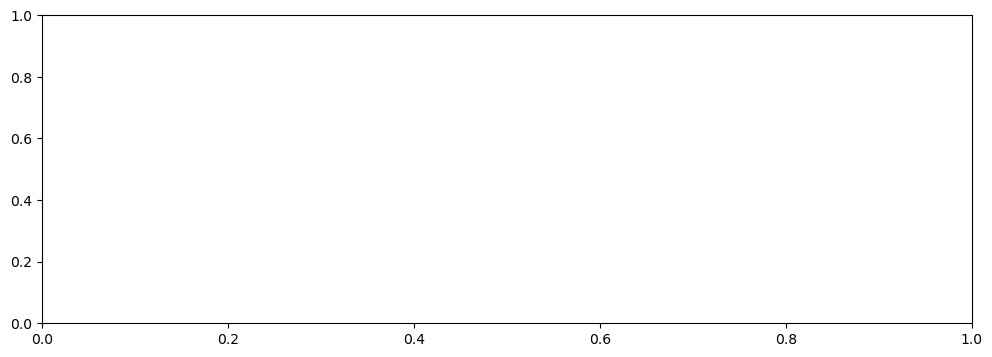

In [103]:
score_dict = {}

model_name = model.__class__.__name__
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=LGBMRegressor(**study.best_params),
    X=df.drop(columns='price'),
    y=df['price'],
    train_sizes=train_sizes,
    cv=5,
    scoring=inverse_rmse_scorer,
    shuffle=True
)

# Compute the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Save the scores
score_dict[model_name] = {
    'train sizes': train_sizes,
    'train mean': train_mean,
    'test mean': test_mean,
    'train std': train_std,
    'test std': test_std
}

In [113]:
def plot_learnin_curve(train_sizes: 'array or list',
                       train_mean: 'array or list',
                       test_mean: 'array or list',
                       train_std: 'array or list',
                       test_std: 'array or list',
                       model_name: 'name of model as string',
                       metric: 'metric as string'):

    fig, ax = plt.subplots(figsize=(4,4))

    ax.plot(train_sizes, train_mean, label=f'Training {metric}')
    ax.plot(train_sizes, test_mean, label=f'Validation {metric}')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel(f'{metric}')
    ax.set_title(f'Learning Curve {model_name}', loc='left')
    ax.legend(loc='best')
    ax.grid(True)

    plt.tight_layout()
    plt.show()

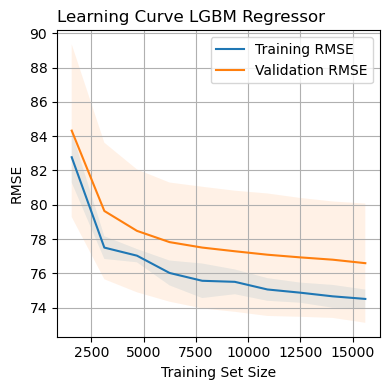

In [114]:
plot_learnin_curve(
    train_sizes=train_sizes,
    train_mean=train_mean,
    test_mean=test_mean,
    train_std=train_std,
    test_std=test_std,
    model_name= 'LGBM Regressor',
    metric='RMSE'
)